# MIMIC-III EDA
This notebook explores the mimic dataset. Specific focus will be on the NOTEEVENTS table.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import timeit
import re
from src.query_athena import QueryAthena

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## 0. Connect to DB and read in table(s)

### Instantiate a QueryAthena object and read in noteevents

In [4]:
athena = QueryAthena()

### Read in the NOTEEVENTS table

In [5]:
# %%timeit -n 1 -r 1
query = "select * from noteevents"
noteevents = athena.run_query(query)

Execution ID: 8ccfedc6-2a5e-4c39-ae51-700e6459d2cb
QUEUED
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
RUNNING
SUCCEEDED
Query "select * from noteevents" finished.


In [6]:
noteevents.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,174,22532,167853.0,2151-08-04 00:00:00.000,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14 00:00:00.000,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25 00:00:00.000,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18 00:00:00.000,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25 00:00:00.000,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


### Explore the NOTEEVENTS table

In [11]:
noteevents.describe()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,cgid
count,2.083180e+06,2.083180e+06,1.851344e+06,2083180,1766614,1246404,1.246404e+06
mean,1.041590e+06,3.242564e+04,1.498796e+05,2151-06-09 06:46:36.745746432,2151-06-05 12:54:37.410410496,2151-05-21 01:23:54.954690560,1.771630e+04
min,1.000000e+00,2.000000e+00,1.000010e+05,2097-12-07 00:00:00,2097-12-07 12:55:00,2097-12-07 13:02:00,1.401000e+04
25%,5.207958e+05,1.146500e+04,1.251950e+05,2126-10-17 00:00:00,2126-10-24 13:26:15.000000512,2126-10-25 12:18:53.249999872,1.580300e+04
50%,1.041590e+06,2.344400e+04,1.496010e+05,2151-03-08 00:00:00,2151-03-08 02:31:00,2151-03-08 06:23:12.999999488,1.759300e+04
75%,1.562385e+06,5.077200e+04,1.748120e+05,2176-07-11 00:00:00,2176-07-09 03:54:00,2176-07-16 18:33:02.250000384,1.959900e+04
max,2.083180e+06,9.999900e+04,1.999990e+05,2210-10-01 00:00:00,2210-10-01 09:58:00,2209-02-11 14:38:11,2.157000e+04
std,6.013624e+05,2.755425e+04,2.878059e+04,NaN,NaN,NaN,2.158703e+03


In [12]:
noteevents.category.unique()

array(['Discharge summary', 'Physician ', 'Nursing', 'Rehab Services',
       'Nutrition', 'Respiratory ', 'Social Work', 'General',
       'Nursing/other', 'Case Management ', 'Radiology', 'Pharmacy',
       'Consult', 'Echo', 'ECG'], dtype=object)

In [13]:
noteevents.category.value_counts()

category
Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: count, dtype: int64

Nearly 60K discharge summaries! Let's investigate further.

### Sample 5 discharge summaries and print the text. What are we working with?

In [14]:
dschg = noteevents[noteevents.category == 'Discharge summary'].reset_index(drop = True)
first_d_text = dschg.sample(n=1, random_state = 345).text.iloc[0]
dschg.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text
0,20030,6649,107611.0,2176-11-04,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2176-10-22**] Discha...
1,20031,14975,175984.0,2182-01-07,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2182-1-3**] D...
2,20032,14975,127677.0,2182-05-06,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2182-5-1**] D...
3,20033,14975,101833.0,2182-06-05,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2182-5-30**] ...
4,20034,257,179006.0,2112-12-23,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2112-12-20**] Discha...


Look at their texts

In [15]:
for _, row in dschg.sample(n=5, random_state = 123).iterrows():
    print('='*100 + '\nSTART\n'+ '='*100)
    print(row.text)
    print('='*100 + '\nEND\n'+ '='*100)
    print('\n\n')

START
Admission Date:  [**2133-2-22**]              Discharge Date:   [**2133-2-24**]

Date of Birth:  [**2065-10-3**]             Sex:   M

Service: MEDICINE

Allergies:
Atenolol / MS Contin

Attending:[**Last Name (NamePattern4) 290**]
Chief Complaint:
COPD exacerbation


Major Surgical or Invasive Procedure:
none

History of Present Illness:
Mr. [**Known lastname 13621**] is a 66-year-old smoker with a history of severe
emphysematous COPD (not on home O2, current smoker), recent
DVT/PE ([**1-1**]) now off coumadin, AAA, HTN, and multiple
admissions for pneumonia who presented with dyspnea and is
transferred to the [**Hospital Unit Name 153**] for management of likely COPD
exacerbation requiring BiPAP.
.
He has been hospitalized multiple times for COPD exacerbation
and pneumonia requiring ICU admission and intubation on a single
occasion in [**2131-9-23**], and most recent admission to [**Hospital1 18**] was
9/[**2131**]. He was in his usual state of health, (at baseline is
unable to

## 1. What is the distribution of discharge summary lengths?
I want to get a good idea of how long the typical discharge summary is. This involves defining a word tokenizer and getting the counts.

In [164]:
# Get words only
re.findall(r'\b\w+\b', first_d_text)

['Admission',
 'Date',
 '2103',
 '7',
 '21',
 'Discharge',
 'Date',
 '2103',
 '7',
 '31',
 'Date',
 'of',
 'Birth',
 '2045',
 '8',
 '8',
 'Sex',
 'M',
 'Service',
 'CARDIOTHORACIC',
 'Allergies',
 'Patient',
 'recorded',
 'as',
 'having',
 'No',
 'Known',
 'Allergies',
 'to',
 'Drugs',
 'Attending',
 'First',
 'Name3',
 'LF',
 '1267',
 'Chief',
 'Complaint',
 'chest',
 'pain',
 'Major',
 'Surgical',
 'or',
 'Invasive',
 'Procedure',
 'Cardiac',
 'catheterization',
 'CABG',
 'x',
 '4',
 'History',
 'of',
 'Present',
 'Illness',
 '57',
 'yo',
 'male',
 'smoker',
 'with',
 'no',
 'significant',
 'past',
 'medical',
 'history',
 'who',
 'presented',
 'initially',
 'to',
 'Hospital6',
 '3105',
 'in',
 'the',
 'evening',
 'of',
 '7',
 '21',
 'At',
 '3',
 'p',
 'm',
 'while',
 'on',
 'his',
 'postal',
 'route',
 'he',
 'was',
 'walking',
 'and',
 'began',
 'having',
 'crushing',
 'substernal',
 'chest',
 'pressure',
 'in',
 'addition',
 'to',
 'diaphoresis',
 'and',
 'lightheadedness',
 'no',

### Get word counts for all texts

In [165]:
%%timeit -n 1 -r 1
noteevents['word_count'] = noteevents.text.apply(lambda x: len(re.findall(r'\b\w+\b', x)))

1min 52s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [166]:
noteevents.head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text,word_count
0,2077385,31805,144147.0,2114-10-13,2114-10-13 16:36:00,2114-10-13 16:44:00,Nursing/other,Report,19072.0,None,0700-[**2037**] PCA Progress Note\n\n\nDEV:\nO...,252
1,2077386,31805,144147.0,2114-10-13,2114-10-13 16:36:00,2114-10-13 18:14:00,Nursing/other,Report,17587.0,None,0700-[**2037**] PCA Progress Note\nI have exam...,28
2,2077387,31805,144147.0,2114-10-14,2114-10-14 03:22:00,2114-10-14 03:39:00,Nursing/other,Report,14461.0,None,3. G&D\nTemps stable in an open crib. Moved to...,255
3,2077468,31843,172449.0,2193-09-21,2193-09-21 18:13:00,2193-09-21 18:15:00,Nursing/other,Report,17681.0,None,NURSING PROGRESS NOTE\nINFANT IN NICU FOR SEPS...,32
4,2078539,31949,136069.0,2163-12-16,2163-12-16 16:48:00,2163-12-16 17:57:00,Nursing/other,Report,20680.0,None,PCA Note: 0700-1900\nNursing Addendum:\n\nI ha...,150


In [167]:
print(sns.color_palette('Blues'))

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429), (0.7309496347558632, 0.8394771241830065, 0.9213225682429834), (0.5356862745098039, 0.746082276047674, 0.8642522106881968), (0.32628988850442137, 0.6186236063052672, 0.802798923490965), (0.16696655132641292, 0.48069204152249134, 0.7291503267973857), (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]


C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


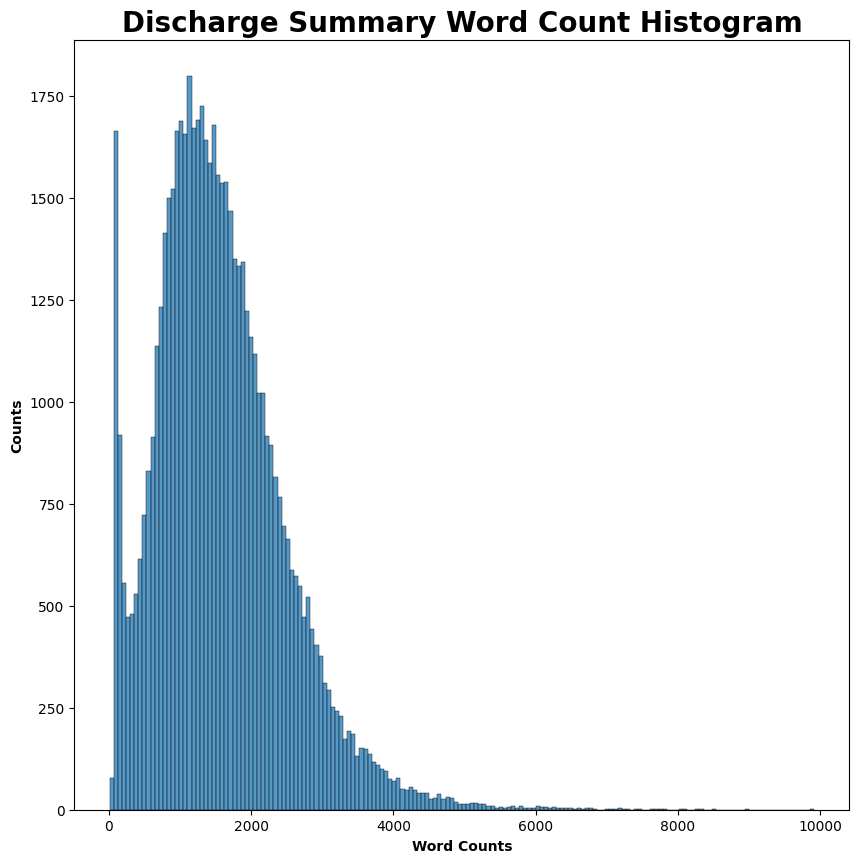

In [217]:
dschg_counts = noteevents[noteevents.category=='Discharge summary'][['word_count']]
plt.figure(figsize = (10,10))
plot = sns.histplot(data = dschg_counts,x = 'word_count')
plot.set_title('Discharge Summary Word Count Histogram', fontdict = {'size': 20, 'weight': 'bold'})
plot.set_xlabel('Word Counts', {'size': 10, 'weight': 'bold'})
plot.set_ylabel('Counts', {'size': 10, 'weight': 'bold'})
# plot.set(title = 'Discharge Summary Word Count Histogram', xlabel = 'Word Counts', fontdict = {'size': 30, 'weight': 'bold'})
plt.savefig('ds_wc_hist.png')
plt.show()

In [26]:
dschg_counts.describe()

,word_count
count,59652.000000
mean,1568.525816
std,909.621371
min,9.000000
25%,942.000000
50%,1453.000000
75%,2068.000000
max,9919.000000


## 2. What are the common headers seen in the discharge summaries?
The main idea I have is to summarize/generate text for discharge summaries. ML models work well on a niche problem. Given Discharge summaries are generally broken into sections and can be long, we want to get an idea of what sections/headers they contain. This will allow me to narrow the scope of the project to focus on a subset(s) of headers) to summarize/generate.

### Develop regex logic to capture possible headers

In [27]:
exclusion_headers = ['admission date', 'discharge date', 'date of birth', 'sex', 'service']

def get_discharge_headers(text):
    
    pattern = r'\n\n([^0-9].*?):[\n\s+]'
    matches = re.findall(pattern, text, re.DOTALL)
    match_list = []
    
    for match in matches:
        curr_match = None
        # print(match)
        # print(len(match))
        if len(match)<40:
            index = text.find(f"\n\n{match}:")+len(match)
            # print(text[index:index+10])
            if '[' not in text[index:index+10]:
            # print(match)
                curr_match = match.replace('\n', '')
                
        else:
            # print('trying by implementing heuristics')
            substring = "\n\n"
            index = match.rfind(substring)  # Find the last occurrence of the substring
            
            if index != -1:
                result = match[index+len(substring):]  # Extract the substring from the last occurrence to the end
                # print(result)
                index = text.find(f"\n\n{result}:")+len(result)
                # print(text[index:index+10])
                if '[' not in text[index:index+10] and not re.match(r'^\d', result):
                    curr_match = result.replace('\n', '')

        if (curr_match) and (curr_match.lower() not in exclusion_headers) and (len(curr_match)<50):
            match_list.append(curr_match.upper())
    
    return match_list
    
text = dschg.sample(n=5, random_state = 123).text.iloc[0]
# print(repr(text))
get_discharge_headers(text)



['CHIEF COMPLAINT',
 'HISTORY OF PRESENT ILLNESS',
 'PAST MEDICAL HISTORY',
 'ALLERGIES',
 'MEDICATIONS ON PRESENTATION',
 'SOCIAL HISTORY',
 'PHYSICAL EXAMINATION ON PRESENTATION',
 'LABORATORY EVALUATION ON PRESENTATION',
 'HOSPITAL COURSE',
 'DISCHARGE DIAGNOSES',
 'DISCHARGE  MED']

Awesome! This looks right... Let's see how it does on the dataset.

In [177]:
%%timeit -n 1 -r 1
noteevents.loc[noteevents.category == 'Discharge summary', 'headers'] = noteevents.loc[noteevents.category == 'Discharge summary'].text.apply(lambda x: get_discharge_headers(x))
noteevents.loc[noteevents.category == 'Discharge summary', 'header_counts'] = noteevents.loc[noteevents.category == 'Discharge summary'].headers.apply(lambda x: len(x))

4.74 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [178]:
noteevents[noteevents.category == 'Discharge summary'].head()

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text,word_count,headers,header_counts
226,174,22532,167853.0,2151-08-04,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2151-7-16**] Dischar...,123,"[RADIOLOGIC STUDIES, HEAD CT, ABDOMINAL CT]",3.0
227,175,13702,107527.0,2118-06-14,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2118-6-2**] Discharg...,2066,"[HISTORY OF PRESENT ILLNESS, REVIEW OF SYSTEMS...",15.0
228,176,13702,167118.0,2119-05-25,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2119-5-4**] D...,1580,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",14.0
229,177,13702,196489.0,2124-08-18,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2124-7-21**] ...,2854,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",22.0
230,178,26880,135453.0,2162-03-25,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2162-3-3**] D...,2242,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",27.0


In [179]:
for _, row in noteevents[noteevents.category == 'Discharge summary'].sample(n=5, random_state = 123).iterrows():
    print('='*100 + '\nSTART\n'+ '='*100)
    print('\nTEXT\n'+ '='*100)
    print(row.text)
    print('\nHEADERS\n'+ '='*100)
    print(row.headers)
    print('='*100 + '\nEND\n'+ '='*100)
    print('\n\n')

START

TEXT
Admission Date:  [**2192-3-12**]       Discharge Date:  [**2192-4-22**]

Date of Birth:   [**2144-5-11**]       Sex:  M

Service:  [**Doctor Last Name 1181**] MEDICINE

CHIEF COMPLAINT:  Buttock pain.

HISTORY OF PRESENT ILLNESS:  The patient is a 47-year-old man
recently admitted to [**Hospital6 1129**] with a
perirectal abscess.  He left the hospital against medical
advice and presented to the [**Hospital1 188**] on the date of admission for re-evaluation.  While the
patient initially wanted re-evaluation, he became
increasingly agitated in the Emergency Department.  Received
a total of 20 mg of Haloperidol intravenously for sedation, 6
mg of Ativan, 1 mg of cogentin, and was then briefly admitted
to the Medical Intensive Care Unit for monitoring.  He was
then transferred to the Medical Service for further
evaluation.

Of note prior to admission, the patient received two doses of
Vancomycin on [**3-12**], one dose of Zosyn as well as one
dose of levofloxacin.  On the morn

It is not perfect, but it is good enough.

In [180]:
dschg_headers = noteevents[noteevents.category=='Discharge summary'][['subject_id', 'headers']].explode('headers')
dschg_headers.head()

,subject_id,headers
226,22532,RADIOLOGIC STUDIES
226,22532,HEAD CT
226,22532,ABDOMINAL CT
227,13702,HISTORY OF PRESENT ILLNESS
227,13702,REVIEW OF SYSTEMS IS NEGATIVE FOR THE FOLLOWING


### Get top seen headers

In [181]:
print(dschg_headers.headers.nunique())
header_count = dschg_headers.headers.value_counts().reset_index().rename(columns={"index": "header", 0: "count"})
top_100_headers = header_count[:100]

65143


In [182]:
top_100_headers

,headers,count
0,ALLERGIES,49835
1,PAST MEDICAL HISTORY,47964
2,DISCHARGE MEDICATIONS,43796
3,DISCHARGE DISPOSITION,43712
4,SOCIAL HISTORY,43638
5,DISCHARGE DIAGNOSIS,41728
6,MEDICATIONS ON ADMISSION,41154
7,FAMILY HISTORY,40547
8,DISCHARGE CONDITION,40324
9,HISTORY OF PRESENT ILLNESS,39118


#### 'CONCISE SUMMARY OF HOSPITAL COURSE' is the same as 'BRIEF HOSPITAL COURSE'... maybe we should cluster the text to get a unique set of headers. Could be a lot of effort for little reward...

In [183]:
header_count[header_count.headers == 'CONCISE SUMMARY OF HOSPITAL COURSE']

,headers,count
305,CONCISE SUMMARY OF HOSPITAL COURSE,110


#### barplot of top 20 headers

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


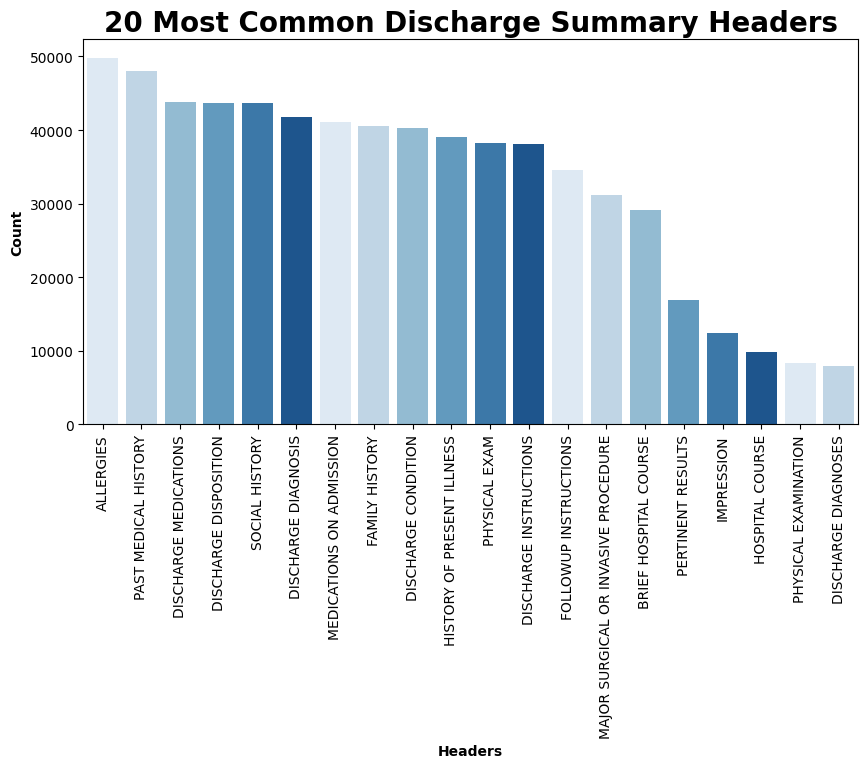

In [222]:
plt.figure(figsize = (10,5))
plot = sns.barplot(data = header_count[:20], x = 'headers', y = 'count', palette = sns.color_palette('Blues'))
# plot.set(title = '20 Most Common Discharge Summary Headers', xlabel = 'Headers', ylabel = 'Count')
plot.set_title('20 Most Common Discharge Summary Headers', fontdict = {'size': 20, 'weight': 'bold'})
plot.set_xlabel('Headers', {'size': 10, 'weight': 'bold'})
plot.set_ylabel('Count', {'size': 10, 'weight': 'bold'})
plt.xticks(rotation=90)
plt.savefig('ds_ch_bar.png', bbox_inches = 'tight')
plt.show()

#### What is the distribution of header counts for discharge summaries?

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


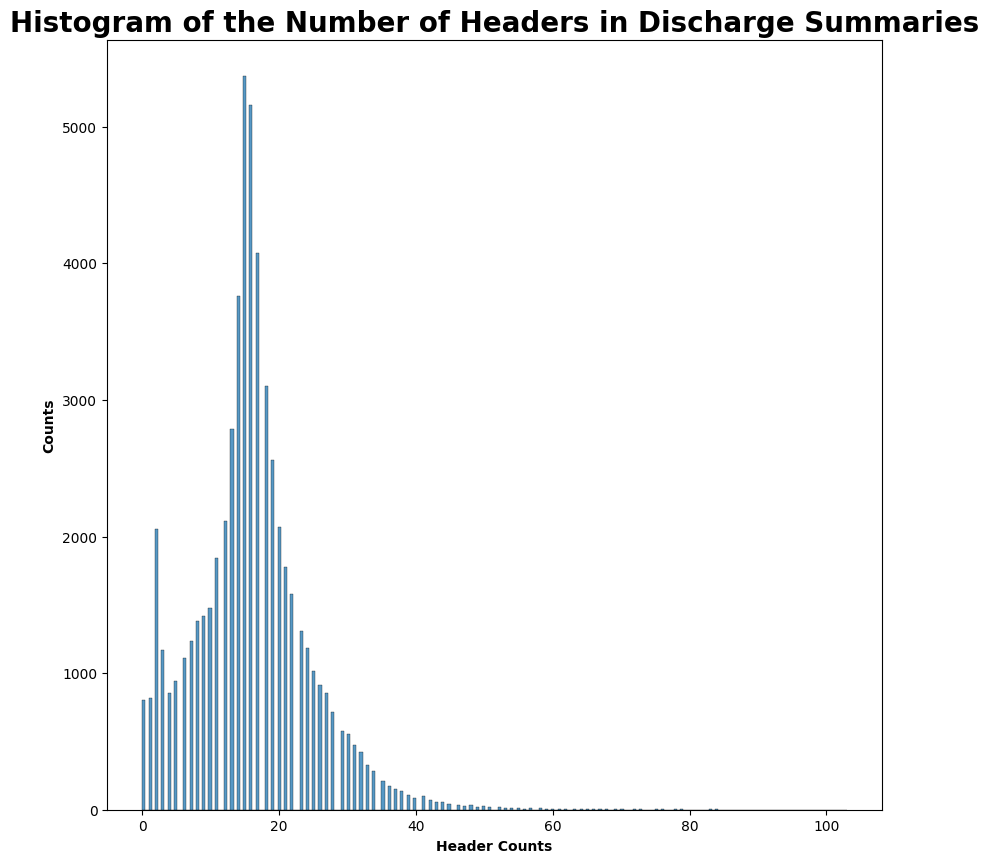

In [221]:
header_counts = noteevents[noteevents.category=='Discharge summary'][['header_counts']]
plt.figure(figsize = (10,10))
plot = sns.histplot(data = header_counts,x = 'header_counts')
plot.set_title('Histogram of the Number of Headers in Discharge Summaries', fontdict = {'size': 20, 'weight': 'bold'})
plot.set_xlabel('Header Counts', {'size': 10, 'weight': 'bold'})
plot.set_ylabel('Counts', {'size': 10, 'weight': 'bold'})
# plot.set(title = 'Histogram of the Number of Headers in Discharge Summaries', xlabel = 'Header Count')
plt.savefig('ds_hc_hist.png', bbox_inches = 'tight')
plt.show()


In [186]:
header_counts.describe()

,header_counts
count,59652.000000
mean,15.999396
std,8.491185
min,0.000000
25%,11.000000
50%,16.000000
75%,20.000000
max,103.000000


## 3. What other note events do the subjects have?

### Do all subjects have a discharge summary?

In [187]:
ds_by_subj = noteevents.groupby('subject_id').agg({'category': lambda x: True if 'Discharge summary' in list(x) else False}).reset_index().rename(columns = {'category': 'ds_present'})
ds_by_subj.ds_present.value_counts()

ds_present
True     41127
False     5019
Name: count, dtype: int64

No, they do not. Let's filter on that subset.

In [188]:
subjs_w_ds = ds_by_subj[ds_by_subj.ds_present == True].subject_id.tolist()
len(subjs_w_ds)

41127

In [189]:
ne_ds = noteevents[noteevents.subject_id.isin(subjs_w_ds)].reset_index(drop = True)

In [190]:
ne_ds.shape

(2053459, 14)

In [191]:
pivot_ne_ds = ne_ds[['subject_id', 'hadm_id', 'category']].pivot_table(index=['subject_id', 'hadm_id'], columns='category', aggfunc='size', fill_value=0).reset_index()
pivot_ne_ds.head()

category,subject_id,hadm_id,Case Management,Consult,Discharge summary,ECG,Echo,General,Nursing,Nursing/other,Nutrition,Pharmacy,Physician,Radiology,Rehab Services,Respiratory,Social Work
0,3,145834.0,0,0,1,9,3,0,0,19,0,0,0,14,0,0,0
1,4,185777.0,0,0,1,1,1,0,0,4,0,0,0,7,0,0,0
2,6,107064.0,0,0,1,1,0,0,0,7,0,0,0,11,0,0,0
3,9,150750.0,0,0,2,2,0,0,0,21,0,0,0,10,0,0,0
4,10,184167.0,0,0,1,0,0,0,0,40,0,0,0,1,0,0,0


In [192]:
pivot_ne_ds.describe()

category,subject_id,hadm_id,Case Management,Consult,Discharge summary,ECG,Echo,General,Nursing,Nursing/other,Nutrition,Pharmacy,Physician,Radiology,Rehab Services,Respiratory,Social Work
count,53304.000000,53304.000000,53304.000000,53304.000000,53304.00000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000,53304.000000
mean,35093.037596,149964.208146,0.017785,0.001839,1.11909,2.564704,0.632392,0.152465,4.103745,15.069169,0.174621,0.001914,2.603632,7.028441,0.100912,0.589918,0.047970
std,28540.872335,28900.547900,0.215314,0.070352,0.43005,2.827461,0.954057,0.933103,16.604685,48.148753,1.017110,0.063036,11.431221,9.582510,0.685590,4.165599,0.383376
min,3.000000,100001.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12532.750000,124913.500000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,25207.500000,150058.000000,0.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,57017.750000,174983.250000,0.000000,0.000000,1.00000,3.000000,1.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000
max,99999.000000,199999.000000,21.000000,6.000000,7.00000,53.000000,17.000000,33.000000,616.000000,981.000000,33.000000,5.000000,460.000000,186.000000,25.000000,200.000000,18.000000


In [193]:
pivot_ne_ds[pivot_ne_ds['Discharge summary']>1]

category,subject_id,hadm_id,Case Management,Consult,Discharge summary,ECG,Echo,General,Nursing,Nursing/other,Nutrition,Pharmacy,Physician,Radiology,Rehab Services,Respiratory,Social Work
3,9,150750.0,0,0,2,2,0,0,0,21,0,0,0,10,0,0,0
7,13,143045.0,0,0,2,3,0,0,0,8,0,0,0,5,0,0,0
10,18,188822.0,0,0,3,3,0,0,0,5,0,0,0,1,0,0,0
12,20,157681.0,0,0,2,0,0,0,0,3,0,0,0,1,0,0,0
35,41,101757.0,0,0,2,0,0,0,0,18,0,0,0,8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53212,99691,140367.0,0,0,2,1,0,0,23,0,0,0,9,6,0,1,0
53215,99708,183397.0,0,0,2,2,1,0,0,0,0,0,0,0,0,0,0
53216,99712,159835.0,0,0,2,1,0,0,0,0,0,0,0,2,0,0,0
53245,99814,186518.0,0,0,2,2,0,0,6,0,0,0,2,4,3,1,0


In [194]:
for _, row in ne_ds[(ne_ds.subject_id==18) & (ne_ds.hadm_id == 188822.0) & (ne_ds.category == 'Discharge summary')].sort_values(by = 'charttime').iterrows():
    print(row.description)
    print(row.text)
    print('='*100)

Report
Admission Date:  [**2167-9-30**]              Discharge Date:   [**2167-10-2**]

Date of Birth:  [**2116-11-29**]             Sex:   M

Service: PSYCHIATRY

Allergies:
Bactrim

Attending:[**First Name3 (LF) 7342**]
Chief Complaint:
"I'm just so depressed, I can't do anything"

Major Surgical or Invasive Procedure:
None

History of Present Illness:
Pt reports 3-4 weeks ago he noticed an increase of stress at
work and at home at the same time that he was losing weight to
gain better control over his diabetes (40lb in [**5-15**] weeks).  Pt
reports having increasingly frequent panic attacks which he
controlled with Klonopin and occassional Xanax.  He also noticed
decrease in sleep, energy, concentration, interest and
motivation, and an increase in anhedonia over the past [**2-12**]
weeks.
 His psychiatrist began Zoloft which after 3-4 days made him
jittery and this was switched to Celexa which he seems to be
tolerating better, although his neurovegetative sx seem to
worsen.  He den

#### This subject has two reports from two different services, and then an addition to one report.

In [195]:
ne_ds[(ne_ds.subject_id==18) & (ne_ds.hadm_id == 188822.0)].sort_values(by = 'chartdate')


,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text,word_count,headers,header_counts
160542,143580,18,188822.0,2167-10-01,NaT,NaT,ECG,Report,NaN,None,Normal sinus rhythm. Right bundle-branch block...,23,NaN,NaN
9588,7823,18,188822.0,2167-10-02,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2167-9-30**] ...,1147,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",18.0
55394,55875,18,188822.0,2167-10-02,NaT,NaT,Discharge summary,Addendum,NaN,None,"Name: [**Known lastname 4919**] JR,[**Known f...",136,"[ALLERGIES, MEDICATIONS ON DISCHARGE, DISCHARG...",3.0
895904,882501,18,188822.0,2167-10-02,2167-10-02 16:45:00,NaT,Radiology,CHEST (PORTABLE AP),NaN,None,[**2167-10-2**] 4:45 PM\n CHEST (PORTABLE AP) ...,71,NaN,NaN
1294091,1260777,18,188822.0,2167-10-02,2167-10-02 23:18:00,2167-10-02 23:25:00,Nursing/other,Report,17219.0,None,"TRANSFER NOTE\n50 YR OLD MAN WITH H/O IDDM, BO...",77,NaN,NaN
1296021,1260776,18,188822.0,2167-10-02,2167-10-02 16:19:00,2167-10-02 16:42:00,Nursing/other,Report,20818.0,None,CCU Progress Note:\n\nsee nursing admission no...,198,NaN,NaN
160752,143579,18,188822.0,2167-10-03,NaT,NaT,ECG,Report,NaN,None,Sinus tachycardia. Right bundle-branch block w...,26,NaN,NaN
1294092,1260778,18,188822.0,2167-10-03,2167-10-03 15:09:00,2167-10-03 16:48:00,Nursing/other,Report,15654.0,None,"Pt 83yo female with PMH of Anemia, COPD, Hyper...",368,NaN,NaN
1294093,1260779,18,188822.0,2167-10-03,2167-10-03 16:19:00,2167-10-03 16:56:00,Nursing/other,Report,20866.0,None,CCU Nursing transfer note\nPleas disregard abo...,280,NaN,NaN
1294094,1260780,18,188822.0,2167-10-03,2167-10-03 16:55:00,2167-10-03 16:57:00,Nursing/other,Report,15654.0,None,above note entered on mr [**Known lastname 91*...,14,NaN,NaN


#### Subjects can have multiple Discharge summaries due to addendums and varying services... But it may be hard discern which notes go with which services... Let's just stick with subjects that have one discharge summary.

In [196]:
pivot_filtered = pivot_ne_ds[pivot_ne_ds['Discharge summary']==1]
plot_data = pivot_filtered.describe().loc[['mean', 'std']].T.reset_index().iloc[2:].sort_values(by = 'mean', ascending = False)
plot_data

,category,mean,std
9,Nursing/other,13.399247,42.391182
13,Radiology,6.781283,9.293151
8,Nursing,4.309322,16.860367
12,Physician,2.753095,11.628655
5,ECG,2.506318,2.755465
4,Discharge summary,1.000000,0.000000
15,Respiratory,0.617517,4.239165
6,Echo,0.616240,0.936835
10,Nutrition,0.184232,1.038792
7,General,0.160065,0.955690


In [197]:
means = plot_data['mean'].tolist()
std_devs = plot_data['std'].tolist()

lower_error = [val - std if (val-std)>=0 else 0 for val, std in zip(means, std_devs)]
upper_error = [val + std for val, std in zip(means, std_devs)]

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


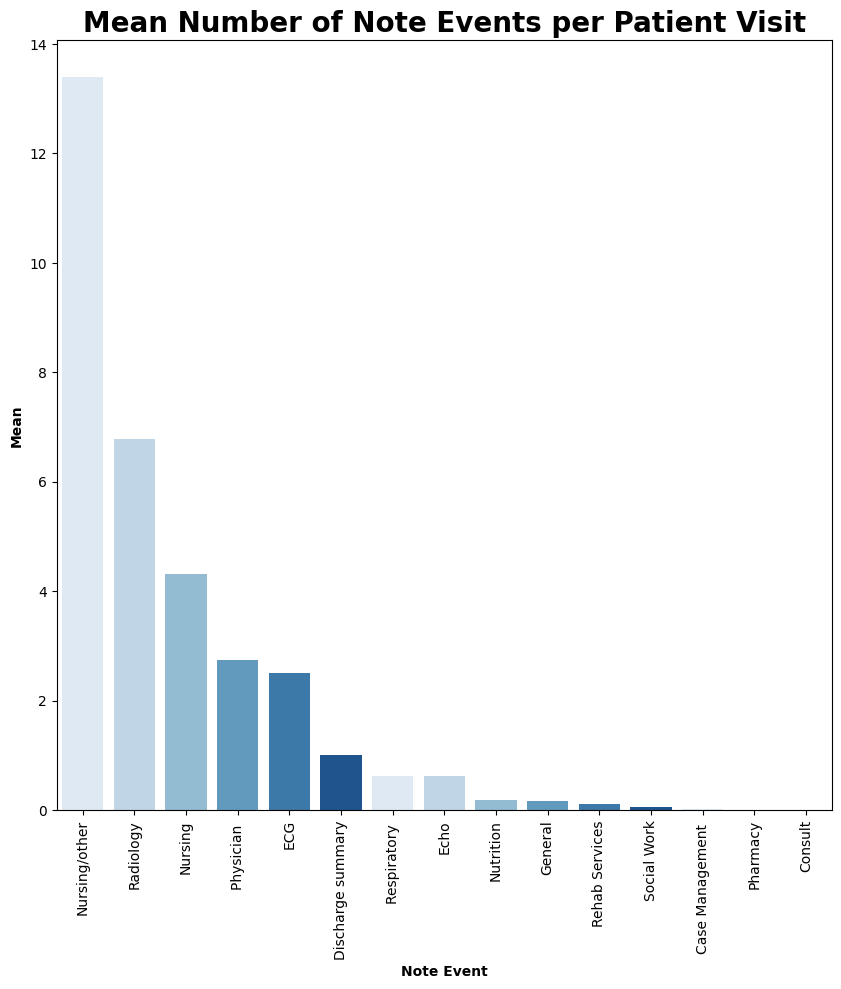

In [232]:

plt.figure(figsize = (10,10))
plot = sns.barplot(data = plot_data, x = 'category', y = 'mean', palette = sns.color_palette('Blues'))
# plot.set(title = 'Mean Number of Note Events per Subject Visit', xlabel = 'Note Event', ylabel = 'Mean')
plot.set_title('Mean Number of Note Events per Patient Visit', fontdict = {'size': 20, 'weight': 'bold'})
plot.set_xlabel('Note Event', {'size': 10, 'weight': 'bold'})
plot.set_ylabel('Mean', {'size': 10, 'weight': 'bold'})
plt.xticks(rotation=90)
plt.savefig('mean_noteevents.png', bbox_inches='tight')
plt.show()

### Do the number of note events correlate with the word count or header count of the discharge summary?
No

In [125]:
ne_ds['num_events'] = ne_ds.category.apply(lambda x: 0 if x == 'Discharge summary' else 1)
ne_ds_grouped = ne_ds.groupby(['subject_id', 'hadm_id']).agg({'num_events': lambda x: sum(x)}).reset_index()

In [126]:
ne_ds_grouped.shape

(53304, 3)

In [130]:
subjs_w_one_ds = pivot_ne_ds[pivot_ne_ds['Discharge summary']==1].subject_id.tolist()
ne_ds_grouped2 = pd.merge(ne_ds_grouped, ne_ds[(ne_ds.subject_id.isin(subjs_w_one_ds)) & (ne_ds.category == 'Discharge summary') & (ne_ds.description == 'Report') ], how = 'inner', on = ['hadm_id', 'subject_id'])
ne_ds_grouped2.head()

,subject_id,hadm_id,num_events_x,row_id,chartdate,charttime,storetime,category,description,cgid,iserror,text,word_count,headers,header_counts,num_events_y
0,3,145834.0,45,44005,2101-10-31,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2101-10-20**] Discharg...,2462,"[CHIEF COMPLAINT, HISTORY OF PRESENT ILLNESS, ...",14.0,0
1,4,185777.0,13,4788,2191-03-23,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2191-3-16**] Discharge...,1635,"[HISTORY OF PRESENT ILLNESS, PAST MEDICAL HIST...",13.0,0
2,6,107064.0,19,20825,2175-06-15,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2175-5-30**] Dischar...,1160,"[ADMISSION DIAGNOSIS, HISTORY OF PRESENT ILLNE...",8.0,0
3,10,184167.0,41,17390,2103-07-06,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2103-6-28**] Dischar...,600,"[PHYSICAL EXAMINATION, HOSPITAL COURSE, GASTRO...",13.0,0
4,11,194540.0,18,30120,2178-05-11,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2178-4-16**] ...,2212,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",38.0,0


In [202]:
ne_ds[(ne_ds.subject_id == 3) & (ne_ds.hadm_id==145834.0)].shape

(46, 14)

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


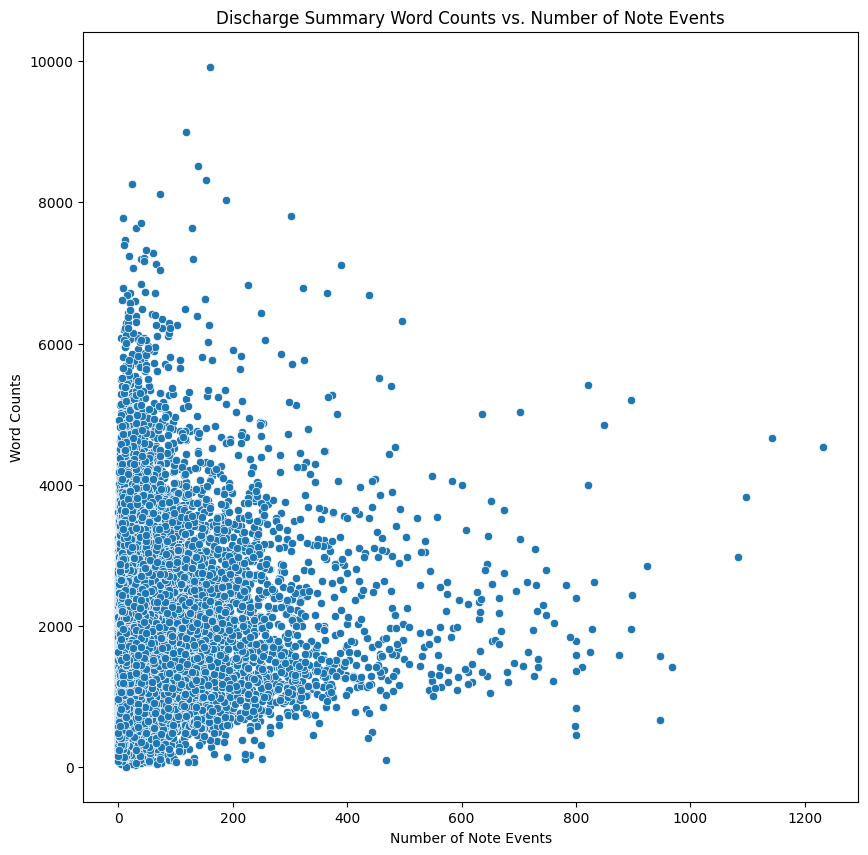

In [203]:
plt.figure(figsize = (10,10))
plot = sns.scatterplot(data = ne_ds_grouped2, x = 'num_events_x', y = 'word_count')
plot.set(title = 'Discharge Summary Word Counts vs. Number of Note Events', xlabel = 'Number of Note Events', ylabel = 'Word Counts')
plt.savefig('wc_v_numevents.png')
plt.show()


C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

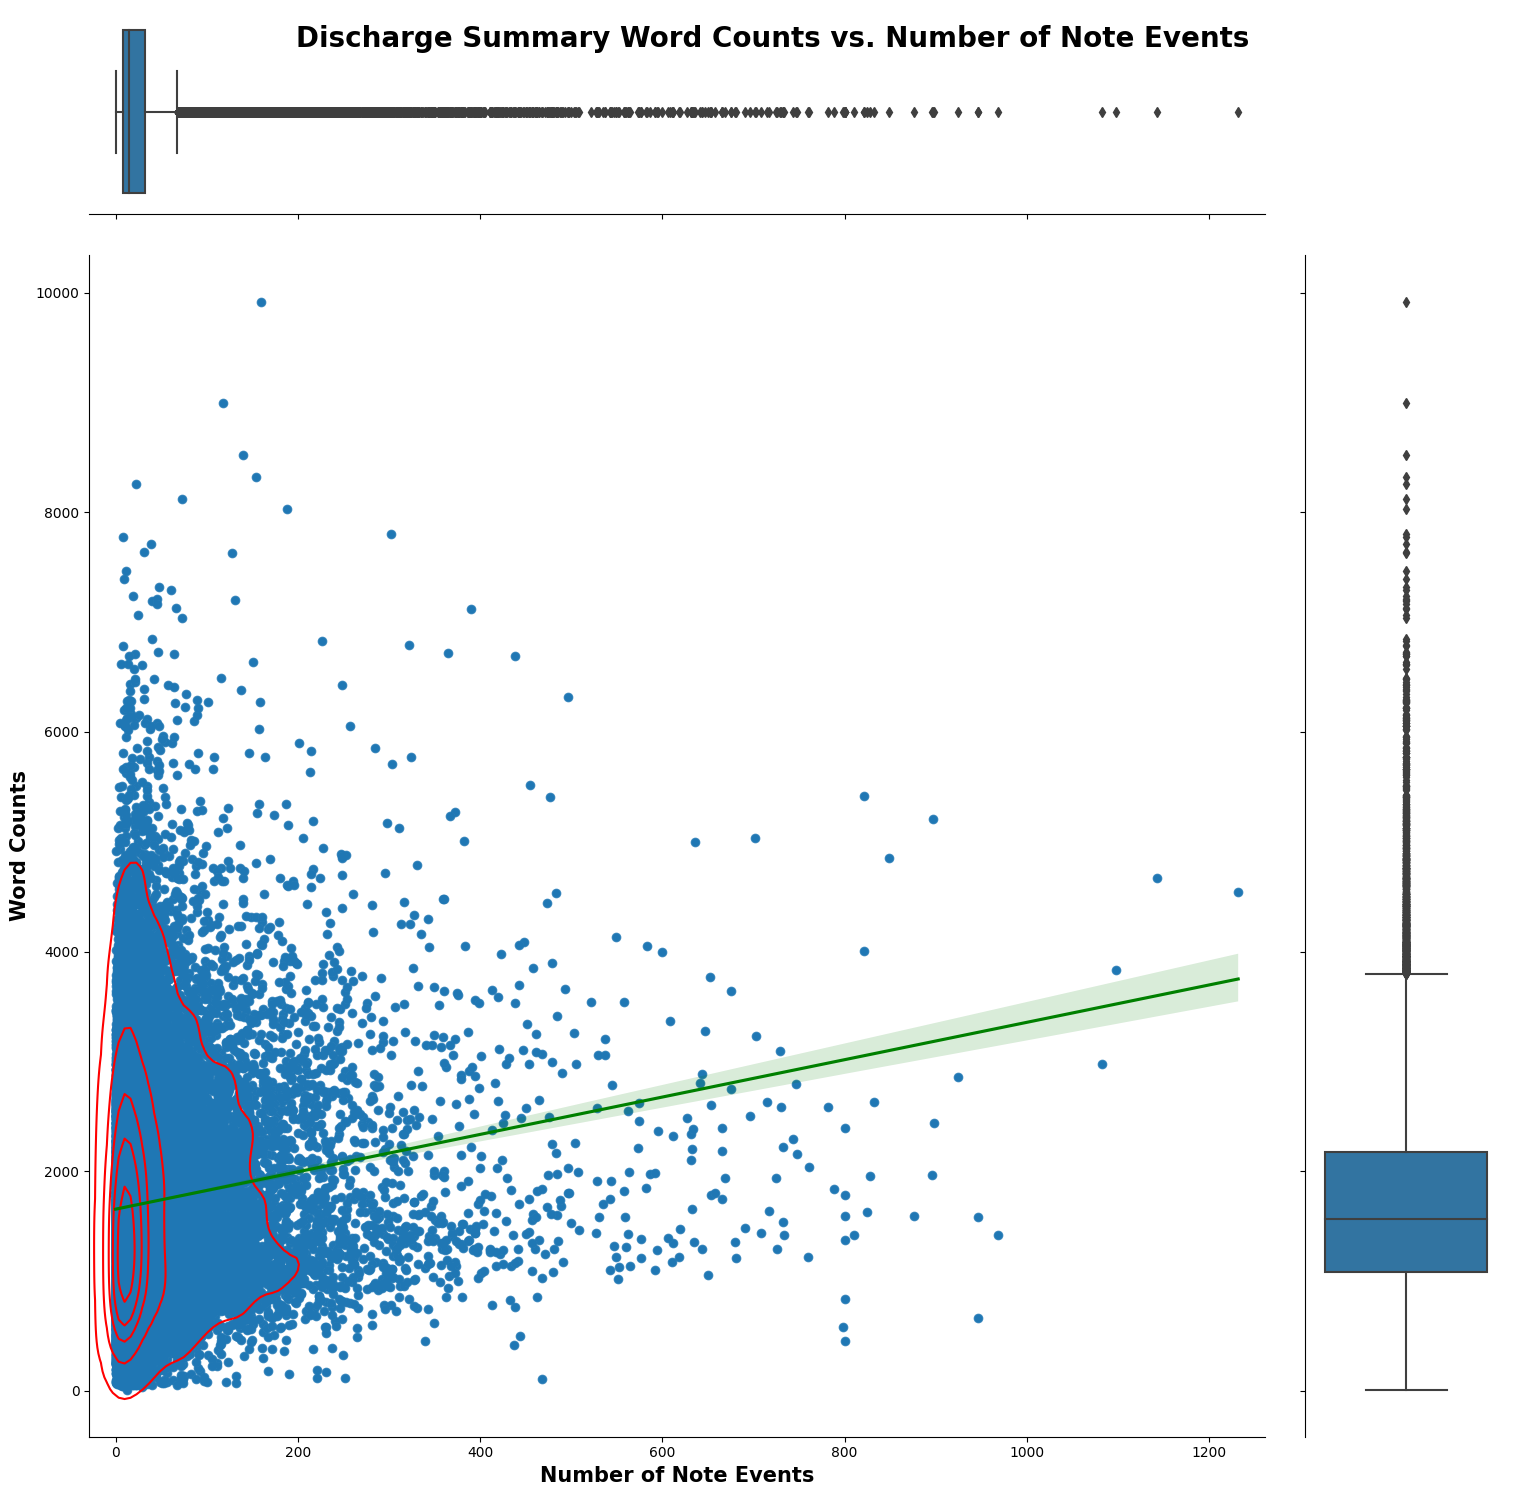

In [258]:
g = sns.JointGrid(data = ne_ds_grouped2, x = 'num_events_x', y = 'word_count', height = 15)
plot = g.plot(sns.scatterplot, sns.boxplot)
plot.fig.suptitle('Discharge Summary Word Counts vs. Number of Note Events', fontsize=20, fontweight = 'bold')
plot.plot_joint(sns.regplot, line_kws={"color": "green"})
plot.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6)
plot.set_axis_labels('Number of Note Events', 'Word Counts', fontsize=15, fontweight = 'bold')
plt.savefig('wc_v_numevents_joint.png', bbox_inches = 'tight')
plt.show()

In [264]:
ne_ds_grouped2.num_events_x.describe()

count    49629.000000
mean        32.146789
std         58.467973
min          0.000000
25%          8.000000
50%         15.000000
75%         32.000000
max       1232.000000
Name: num_events_x, dtype: float64

## 4. Is there a relationship between hospital stay time and length of discharge?

In [54]:
# %%timeit -n 1 -r 1
query = "select * from admissions"
admissions = athena.run_query(query)

C:\Users\dalton\AppData\Local\Temp\ipykernel_16088\2719452924.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  admissions = pd.read_sql_query(query, conn)


In [56]:
admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [57]:
admissions.describe()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,edregtime,edouttime,hospital_expire_flag,has_chartevents_data
count,58976.000000,58976.000000,58976.000000,58976,58976,5854,30877,30877,58976.000000,58976.000000
mean,29488.500000,33755.583288,149970.809584,2151-03-22 15:38:36.768516096,2151-04-01 18:51:27.117810688,2151-02-03 08:11:13.590707200,2151-04-24 10:08:02.123910144,2151-04-24 15:52:40.210511872,0.099261,0.973006
min,1.000000,2.000000,100001.000000,2100-06-07 19:59:00,2100-06-09 17:09:00,2100-06-19 08:15:00,2100-06-07 13:14:00,2100-06-08 00:06:00,0.000000,0.000000
25%,14744.750000,11993.750000,124952.750000,2126-02-22 08:30:00,2126-03-04 11:33:30,2125-12-27 18:15:00,2126-04-07 01:58:00,2126-04-07 08:15:00,0.000000,1.000000
50%,29488.500000,24133.500000,149989.500000,2151-01-15 09:39:00,2151-01-29 16:49:30,2150-09-15 07:08:00,2150-12-12 00:32:00,2150-12-12 03:28:00,0.000000,1.000000
75%,44232.250000,53851.500000,174966.500000,2176-07-09 02:32:00,2176-07-19 13:30:00,2176-01-29 11:05:00,2176-08-30 03:24:00,2176-08-30 05:39:00,0.000000,1.000000
max,58976.000000,99999.000000,199999.000000,2210-08-17 17:13:00,2210-08-24 19:43:00,2208-02-05 11:45:00,2210-08-17 10:14:00,2210-08-17 18:25:00,1.000000,1.000000
std,17025.049075,28092.726225,28883.095213,NaN,NaN,NaN,NaN,NaN,0.299014,0.162067


In [59]:
admissions.admittime

0       2196-04-09 12:26:00
1       2153-09-03 07:15:00
2       2157-10-18 19:34:00
3       2139-06-06 16:14:00
4       2160-11-02 02:06:00
                ...        
58971   2131-03-30 21:13:00
58972   2151-03-05 20:00:00
58973   2200-09-12 07:15:00
58974   2128-11-11 02:29:00
58975   2131-10-25 03:09:00
Name: admittime, Length: 58976, dtype: datetime64[ns]

In [70]:
t1, t2 = np.datetime64('2196-04-09 12:26:00'), np.datetime64('2196-09-03 07:15:00')

In [76]:
type((t1-t2)/np.timedelta64(1, 'h'))

numpy.float64

In [82]:
def find_end_time(dsch, death):
    if pd.isnull(death):
        if not pd.isnull(dsch):
            return dsch
        else:
            return 'NaT'
    elif dsch<death:
        return dsch
    else:
        return death

admissions['endtime'] = admissions.apply(lambda x: find_end_time(x.dischtime, x.deathtime), axis = 1)
admissions['hours_stayed'] = admissions.apply(lambda x: (x.endtime-x.admittime)/np.timedelta64(1, 'h'), axis = 1)
admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,endtime,hours_stayed
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,2196-04-10 15:54:00,27.466667
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,2153-09-08 19:10:00,131.916667
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1,2157-10-25 14:00:00,162.433333
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1,2139-06-09 12:48:00,68.566667
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,2160-11-05 14:55:00,84.816667


In [85]:
dsch_note_admit_merge = pd.merge(noteevents[(noteevents.category == 'Discharge summary') & (noteevents.description == 'Report')], admissions, on = ['subject_id', 'hadm_id'], how = 'inner')

In [95]:
dsch_note_admit_merge.head()

,row_id_x,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,text,word_count,headers,header_counts,row_id_y,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,endtime,hours_stayed
0,174,22532,167853.0,2151-08-04,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2151-7-16**] Dischar...,123,"[RADIOLOGIC STUDIES, HEAD CT, ABDOMINAL CT]",3.0,27478,2151-07-16 14:29:00,2151-08-04 19:10:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,UNOBTAINABLE,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,2151-07-16 04:49:00,2151-07-16 14:20:00,RT LOWER LOBE PNEUMONIA,0,1,2151-08-04 19:10:00,460.683333
1,170,22532,167853.0,2151-08-04,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2151-7-16**] Dischar...,2532,"[HISTORY OF PRESENT ILLNESS, PAST MEDICAL HIST...",15.0,27478,2151-07-16 14:29:00,2151-08-04 19:10:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,UNOBTAINABLE,UNKNOWN (DEFAULT),UNKNOWN/NOT SPECIFIED,2151-07-16 04:49:00,2151-07-16 14:20:00,RT LOWER LOBE PNEUMONIA,0,1,2151-08-04 19:10:00,460.683333
2,175,13702,107527.0,2118-06-14,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2118-6-2**] Discharg...,2066,"[HISTORY OF PRESENT ILLNESS, REVIEW OF SYSTEMS...",15.0,16797,2118-06-02 19:18:00,2118-06-14 15:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,LONG TERM CARE HOSPITAL,Medicare,None,CATHOLIC,MARRIED,WHITE,2118-06-02 08:21:00,2118-06-02 21:53:00,CHRONIC OBSTRUCTIVE PULMONARY DISEASE,0,1,2118-06-14 15:15:00,283.950000
3,176,13702,167118.0,2119-05-25,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2119-5-4**] D...,1580,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",14.0,16798,2119-05-04 07:15:00,2119-05-25 13:30:00,NaT,ELECTIVE,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,TRACHEALBRONCHEAL MALACEA/SDA,0,1,2119-05-25 13:30:00,510.250000
4,177,13702,196489.0,2124-08-18,NaT,NaT,Discharge summary,Report,NaN,None,Admission Date: [**2124-7-21**] ...,2854,"[ALLERGIES, MAJOR SURGICAL OR INVASIVE PROCEDU...",22.0,16799,2124-07-21 16:09:00,2124-08-18 16:26:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2124-07-21 10:44:00,2124-07-21 17:30:00,ASTHMA;COPD EXACERBATION,0,1,2124-08-18 16:26:00,672.283333


C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='hours_stayed', ylabel='word_count'>

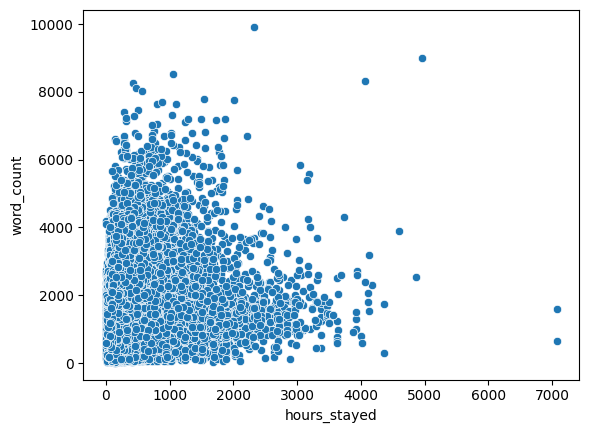

In [102]:
sns.scatterplot(data = dsch_note_admit_merge[dsch_note_admit_merge.hours_stayed>0], x = 'hours_stayed', y = 'word_count')

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

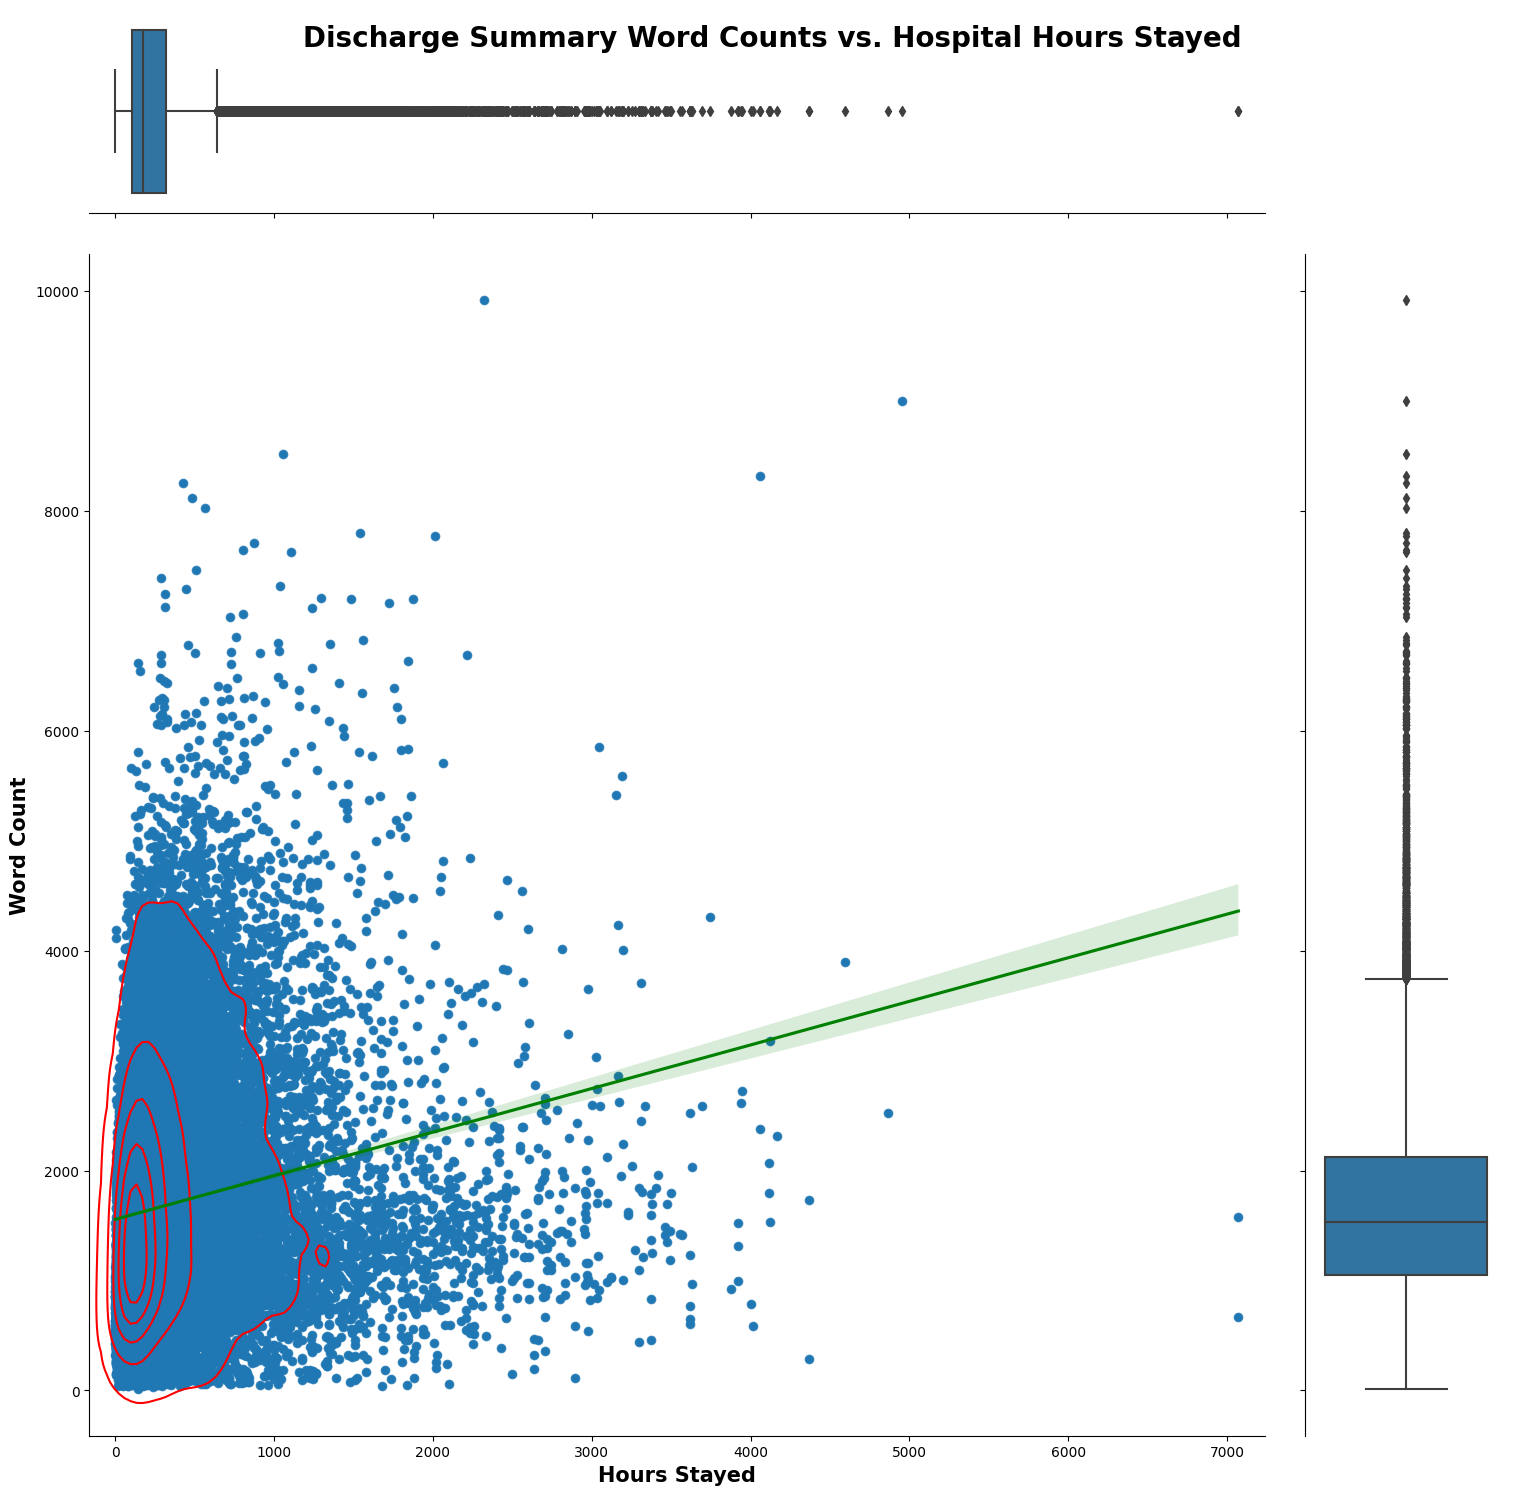

In [259]:
g = sns.JointGrid(data = dsch_note_admit_merge[dsch_note_admit_merge.hours_stayed>0], x = 'hours_stayed', y = 'word_count', height = 15)
plot = g.plot(sns.scatterplot, sns.boxplot)
plot.fig.suptitle('Discharge Summary Word Counts vs. Hospital Hours Stayed', fontsize=20, fontweight = 'bold')
plot.plot_joint(sns.regplot, line_kws={"color": "green"})
plot.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6)
plot.set_axis_labels('Hours Stayed', 'Word Count', fontsize=15, fontweight = 'bold')
plt.savefig('wc_v_hourssstayed_joint.png', bbox_inches = 'tight')
plt.show()

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='hours_stayed', ylabel='header_counts'>

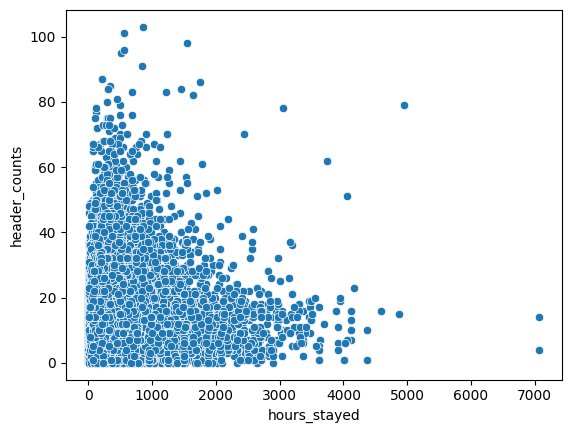

In [103]:
sns.scatterplot(data = dsch_note_admit_merge[dsch_note_admit_merge.hours_stayed>0], x = 'hours_stayed', y = 'header_counts')

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

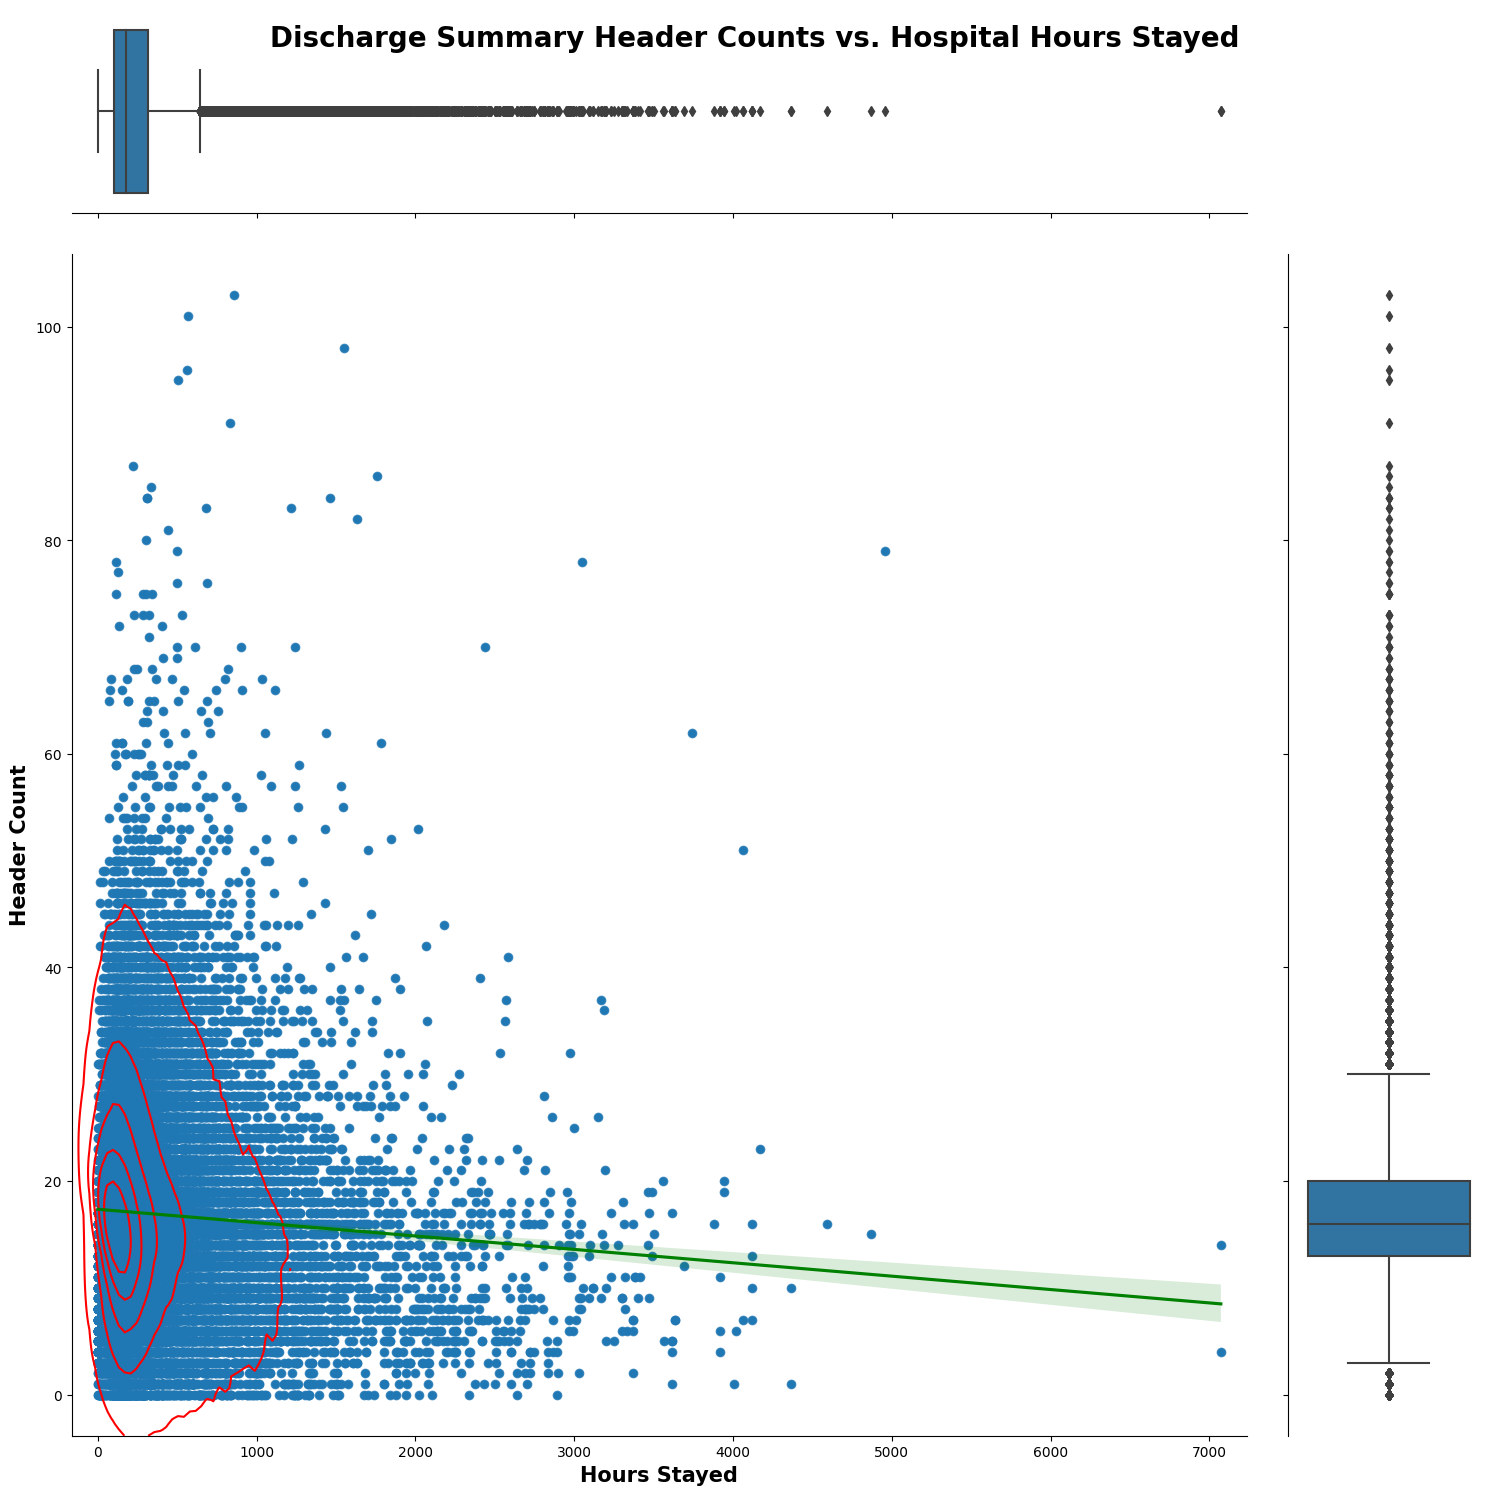

In [263]:
g = sns.JointGrid(data = dsch_note_admit_merge[dsch_note_admit_merge.hours_stayed>0], x = 'hours_stayed', y = 'header_counts', height = 15)
plot = g.plot(sns.scatterplot, sns.boxplot)
plot.fig.suptitle('Discharge Summary Header Counts vs. Hospital Hours Stayed', fontsize=20, fontweight = 'bold')
plot.plot_joint(sns.regplot, line_kws={"color": "green"})
plot.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6)
plot.set_axis_labels('Hours Stayed', 'Header Count', fontsize=15, fontweight = 'bold')
plt.savefig('hc_v_hourssstayed_joint.png', bbox_inches = 'tight')
plt.show()

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='header_counts', ylabel='word_count'>

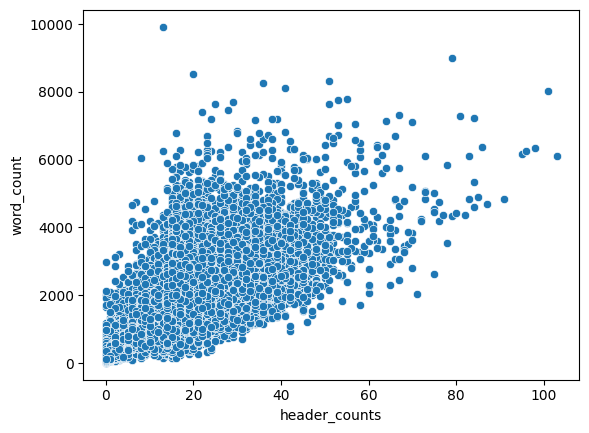

In [104]:
sns.scatterplot(data = dsch_note_admit_merge[dsch_note_admit_merge.hours_stayed>0], x = 'header_counts', y = 'word_count')

C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dalton\anaconda3\envs\ds504_eda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

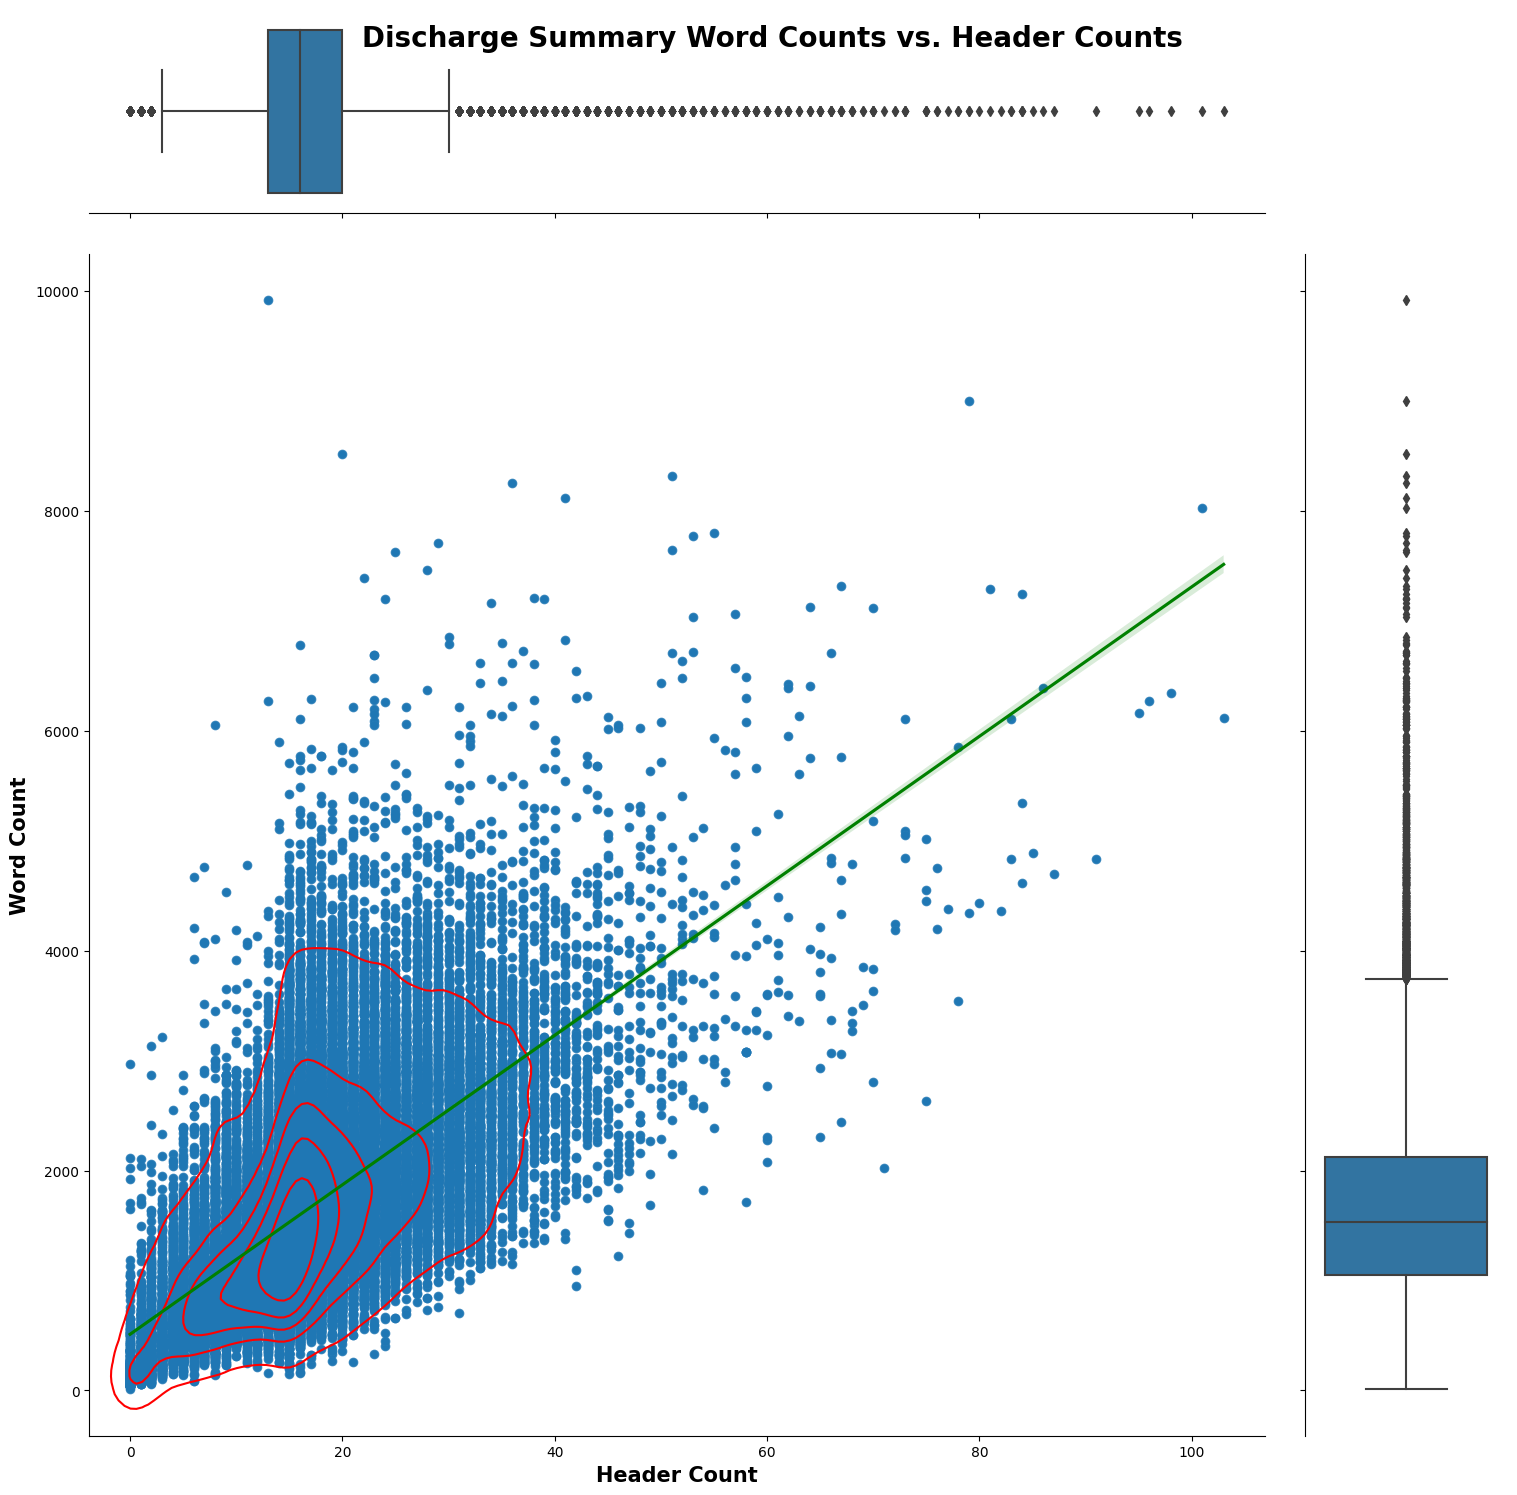

In [261]:
g = sns.JointGrid(data = dsch_note_admit_merge[dsch_note_admit_merge.hours_stayed>0], x = 'header_counts', y = 'word_count', height = 15)
plot = g.plot(sns.scatterplot, sns.boxplot)
plot.fig.suptitle('Discharge Summary Word Counts vs. Header Counts', fontsize=20, fontweight = 'bold')
plot.plot_joint(sns.regplot, line_kws={"color": "green"})
plot.plot_joint(sns.kdeplot, color="r", zorder=1, levels=6)
plot.set_axis_labels('Header Count', 'Word Count', fontsize=15, fontweight = 'bold')
plt.savefig('wc_v_hc_joint.png', bbox_inches = 'tight')
plt.show()